In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import matplotlib.pyplot  as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, roc_auc_score,f1_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from geopy.distance import vincenty
from sklearn.model_selection import GridSearchCV
from scipy import stats
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
from scipy.stats import zscore
import calendar
import pandas as pd
import seaborn as sns
import numpy as np

%matplotlib inline
plt.style.use('seaborn-whitegrid')
dataset_dir = '/content/drive/My Drive/Colab Notebooks/data/ml-rideshare/'

## Load Dataset

In [8]:
def loadDataset():
  #training set
  x_train = pd.read_csv(dataset_dir + 'train.csv')
  tripid_train = x_train.pop('tripid')

  #testset
  x_test = pd.read_csv(dataset_dir + 'test.csv')
  tripid_test = x_test.pop('tripid')
  return x_train,x_test,tripid_train,tripid_test

 ## Data exploration

Training dataset

In [ ]:
# training feature set
x_train,x_test,trainids,testids =  loadDataset()
print("\nTrain set description:\n",x_train.describe())
print("\nTrain set null count:\n",x_train.isnull().sum())

In [ ]:
#training labels
print("Train set lables description:",x_train['label'].describe(),"\n\n")
print(x_train['label'].value_counts().plot.barh(title="Label"))

Visualize features

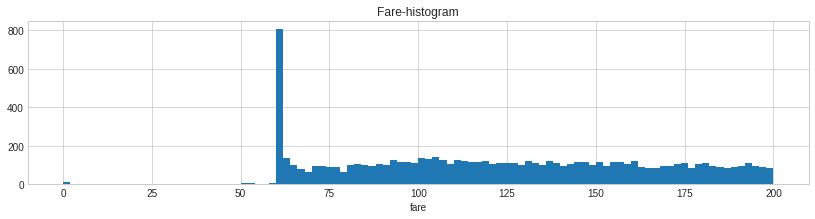

In [24]:
#fare
x_train[x_train.fare<200].fare.hist(bins=100, figsize=(14,3))
plt.xlabel('fare')
plt.title('Fare-histogram');

#There is a spike around 60 it could be a fixed price. eg: To/From airport

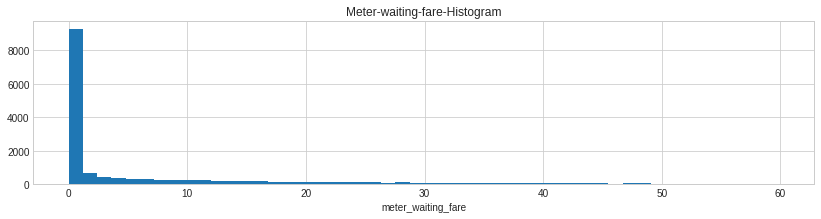

In [25]:
#meter_waiting_fare
x_train[x_train.meter_waiting_fare<60].meter_waiting_fare.hist(bins=50, figsize=(14,3))
plt.xlabel('meter_waiting_fare')
plt.title('Meter-waiting-fare-Histogram');

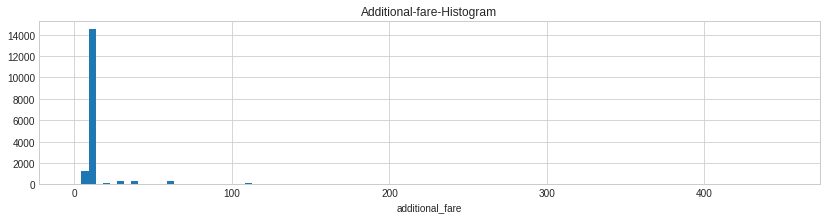

In [26]:
#additional_fare
x_train[x_train.additional_fare<1000].additional_fare.hist(bins=100, figsize=(14,3))
plt.xlabel('additional_fare')
plt.title('Additional-fare-Histogram');

location of trips

In [20]:
#map of the bounding box
sl_map = plt.imread('/content/drive/My Drive/Colab Notebooks/data/ml-rideshare/sl-map.png')

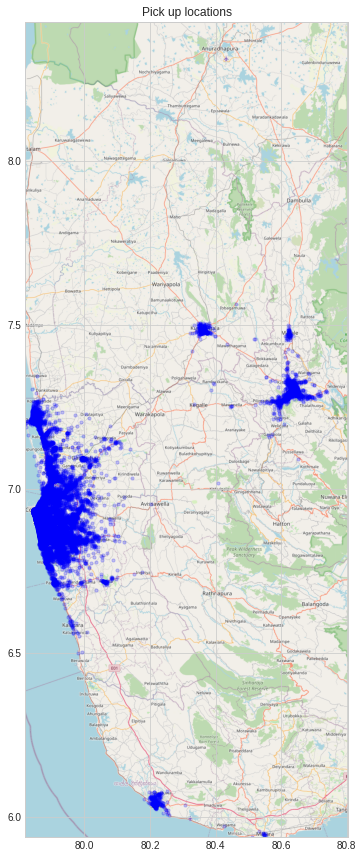

In [21]:
#pickup locations train set
fig, ax = plt.subplots(figsize = (20,15))
ax.scatter(x_train.pick_lon, x_train.pick_lat, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Pick up locations')
ax.set_xlim(79.8177,80.8055)
ax.set_ylim(5.9366,8.42501)
ax.imshow(sl_map, zorder=0, extent = BB, aspect= 'equal')

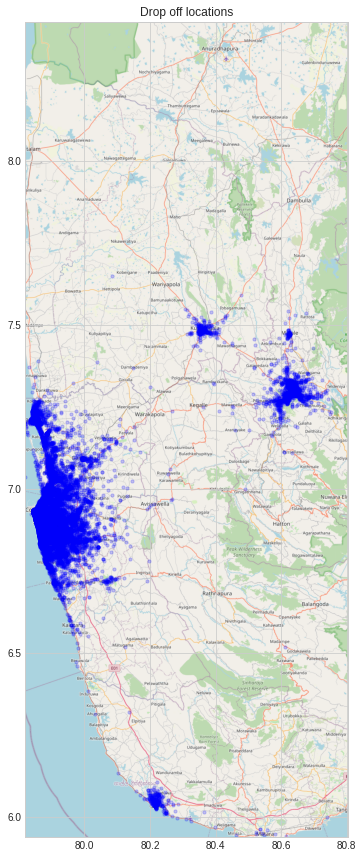

In [22]:
#drop_off locations train set
fig, ax = plt.subplots(figsize = (20,15))
ax.scatter(x_train.drop_lon, x_train.drop_lat, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Drop off locations')
ax.set_xlim(79.8177,80.8055)
ax.set_ylim(5.9366,8.42501)
ax.imshow(sl_map, zorder=0, extent = BB, aspect= 'equal')

#It seems there are no pickup or drop off locations on water

In [23]:
#calculate distance
# create new feature distance
x_train['pick_lat'] = np.radians(x_train["pick_lat"])
x_train['pick_lon'] = np.radians(x_train["pick_lon"])
x_train['drop_lat'] = np.radians(x_train["drop_lat"])
x_train['drop_lon'] = np.radians(x_train["drop_lon"])

x_test['pick_lat'] = np.radians(x_test["pick_lat"])
x_test['pick_lon'] = np.radians(x_test["pick_lon"])
x_test['drop_lat'] = np.radians(x_test["drop_lat"])
x_test['drop_lon'] = np.radians(x_test["drop_lon"])

def distance_calc (row):
    start = (row['pick_lat'], row['pick_lon'])
    stop = (row['drop_lat'], row['drop_lon'])
    return vincenty(start, stop).meters

x_train['distance'] = x_train.apply(
    lambda row: distance_calc(row), axis=1)

x_test['distance'] = x_test.apply(
    lambda row: distance_calc(row), axis=1)

distance of trips

count    17170.000000
mean        79.058619
std         79.950915
min          0.000000
25%         25.959698
50%         56.240709
75%        107.490172
max       1390.235548
Name: distance, dtype: float64

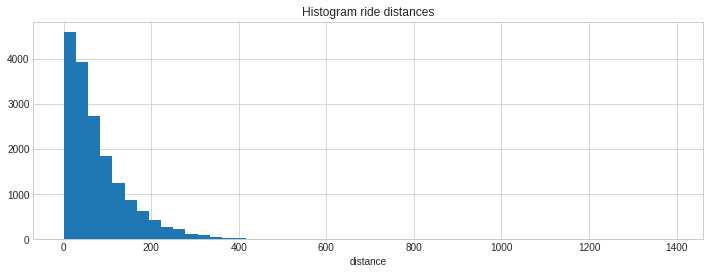

In [27]:
x_train.distance.hist(bins=50, figsize=(12,4))
plt.xlabel('distance')
plt.title('Histogram ride distances')
x_train.distance.describe()

- most of the rides are short rides
- 0 distance rides - noise or same pickup and drop-off locations




avg rates

In [ ]:
print("Average fare/distance : {:0.2f}".format(x_train.fare.sum()/x_train.distance.sum()))
print("Average fare/duration : {:0.2f}".format(x_train.fare.sum()/x_train.duration.sum()))
print("Average duration/distance : {:0.2f}".format(x_train.duration.sum()/x_train.distance.sum()))
#print("Average fare/duration : {:0.2f}".format(x_train.fare.sum()/x_train.duration.sum()))

Average fare/distance : 3.95
Average fare/duration : 0.18
Average duration/distance : 21.49


In [ ]:
# scatter plot distance - fare for correct labels
x_correct = x_train[x_train.label == 'correct']
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(x_correct.distance, x_correct.fare, alpha=0.2)
axs[0].set_xlabel('distance')
axs[0].set_ylabel('fare')
axs[0].set_title('All data')
there are 37 
idx = (x_correct.distance< 400) & (x_correct.fare < 100)
axs[1].scatter(x_correct[idx].distance, x_correct[idx].fare, alpha=0.2)
axs[1].set_xlabel('distance')
axs[1].set_ylabel('fare')
axs[1].set_title('Zoom in on distance < 400 , .format(x_train.fare.sum()/x_train.distance.sum()))fare < 5000');

- There are datapoints with zero distance but non-zero fare: pickup and dropoff at the same location or noise
- There are trips with distance > 100 with a low fare(around 60): Discounted trips or trips near hostpots
- Overall relationship of distance is linear

Duration of trips


In [ ]:
#meter_waiting_fare
x_correct[x_correct.duration<4000].duration.hist(bins=100, figsize=(14,3))
plt.xlabel('duration')
plt.title('Histogram');
x_train.duration.describe()

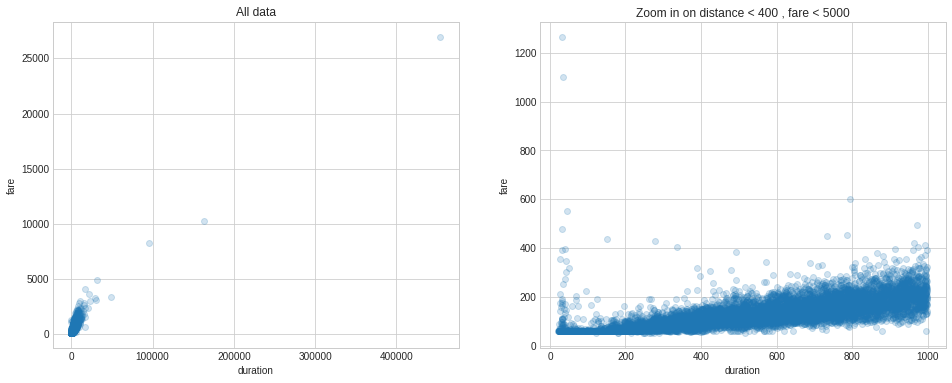

In [ ]:
# scatter plot duration - fare for correct labels
x_correct = x_train[x_train.label == 'correct']
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(x_correct.duration, x_correct.fare, alpha=0.2)
axs[0].set_xlabel('duration')
axs[0].set_ylabel('fare')
axs[0].set_title('All data')

idx = (x_correct.duration< 1000) & (x_correct.fare < 2000)
axs[1].scatter(x_correct[idx].duration, x_correct[idx].fare, alpha=0.2)
axs[1].set_xlabel('duration')
axs[1].set_ylabel('fare')
axs[1].set_title('Zoom in on distance < 400 , fare < 5000');

- A linear relationship
- Has few outliers- low duration comparatively high fare

Datetime

In [ ]:
# Format timestamp to datetime
x_train['pickup_time'] = pd.to_datetime(x_train['pickup_time'], format="%m/%d/%Y  %H:%M" )
x_train['drop_time'] = pd.to_datetime(x_train['drop_time'], format="%m/%d/%Y  %H:%M" )

x_test['pickup_time'] = pd.to_datetime(x_test['pickup_time'], format="%m/%d/%Y  %H:%M" )
x_test['drop_time'] = pd.to_datetime(x_test['drop_time'], format="%m/%d/%Y  %H:%M" )

x_train.rename(columns={'pickup_time':'pickup_datetime','drop_time':'drop_datetime'}, inplace=True)
x_test.rename(columns={'pickup_time':'pickup_datetime','drop_time':'drop_datetime'}, inplace=True)

In [ ]:
#create new features for day,hour,day_of_week,month and year
x_train['pickup_day']=x_train['pickup_datetime'].apply(lambda x:x.day)
x_train['pickup_hour']=x_train['pickup_datetime'].apply(lambda x:x.hour)
x_train['pickup_day_of_week']=x_train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
x_train['pickup_month']=x_train['pickup_datetime'].apply(lambda x:x.month)
x_train['pickup_year']=x_train['pickup_datetime'].apply(lambda x:x.year)

x_train['drop_day']=x_train['drop_datetime'].apply(lambda x:x.day)
x_train['drop_hour']=x_train['drop_datetime'].apply(lambda x:x.hour)
x_train['drop_day_of_week']=x_train['drop_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
x_train['drop_month']=x_train['drop_datetime'].apply(lambda x:x.month)
x_train['drop_year']=x_train['drop_datetime'].apply(lambda x:x.year)


x_test['pickup_day']=x_test['pickup_datetime'].apply(lambda x:x.day)
x_test['pickup_hour']=x_test['pickup_datetime'].apply(lambda x:x.hour)
x_test['pickup_day_of_week']=x_test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
x_test['pickup_month']=x_test['pickup_datetime'].apply(lambda x:x.month)
x_test['pickup_year']=x_test['pickup_datetime'].apply(lambda x:x.year)


x_test['drop_day']=x_test['drop_datetime'].apply(lambda x:x.day)
x_test['drop_hour']=x_test['drop_datetime'].apply(lambda x:x.hour)
x_test['drop_day_of_week']=x_test['drop_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
x_test['drop_month']=x_test['drop_datetime'].apply(lambda x:x.month)
x_test['drop_year']=x_test['drop_datetime'].apply(lambda x:x.year)

x_train.pop('pickup_datetime')
x_train.pop('drop_datetime')
x_test.pop('pickup_datetime')
x_test.pop('drop_datetime')

In [ ]:
x_train.pickup_hour.hist(bins=24, figsize=(12,4))
plt.xlabel('pickup_hour')
plt.title('Histogram pickup_hour')

In [ ]:
print(x_test.pickup_year.unique())
print(x_train.pickup_year.unique())

pickup_year and drop_year doesn't have much of a impact

In [ ]:
x_train = x_train.drop(['pickup_year','drop_year'],axis=1)
x_test = x_test.drop(['pickup_year','drop_year'],axis=1)

# Feature Engineering

In [ ]:
#location data : define a bounding box using the testset
print(min(x_test.pick_lon.min(), x_test.drop_lon.min()),max(x_test.pick_lon.max(), x_test.drop_lon.max()))
print(min(x_test.pick_lat.min(), x_test.drop_lat.min()),max(x_test.pick_lat.max(), x_test.drop_lat.max()))
#remove training data points that are not within the bounding box 
def select_within_boundingbox(df, BB):
    return (df.pick_lon >= BB[0]) & (df.pick_lon <= BB[1]) & \
           (df.pick_lat >= BB[2]) & (df.pick_lat <= BB[3]) & \
           (df.drop_lon >= BB[0]) & (df.drop_lon <= BB[1]) & \
           (df.drop_lat >= BB[2]) & (df.drop_lat <= BB[3])

BB = (79.8177, 80.8055, 5.9366, 8.42501)

print('Old size: %d' % len(x_train))
x_train = x_train[select_within_boundingbox(x_train, BB)]
print('New size: %d' % len(x_train))

In [ ]:
# create new feature distance
x_train['pick_lat'] = np.radians(x_train["pick_lat"])
x_train['pick_lon'] = np.radians(x_train["pick_lon"])
x_train['drop_lat'] = np.radians(x_train["drop_lat"])
x_train['drop_lon'] = np.radians(x_train["drop_lon"])

x_test['pick_lat'] = np.radians(x_test["pick_lat"])
x_test['pick_lon'] = np.radians(x_test["pick_lon"])
x_test['drop_lat'] = np.radians(x_test["drop_lat"])
x_test['drop_lon'] = np.radians(x_test["drop_lon"])

def distance_calc (row):
    start = (row['pick_lat'], row['pick_lon'])
    stop = (row['drop_lat'], row['drop_lon'])
    return vincenty(start, stop).meters

x_train['distance'] = x_train.apply(
    lambda row: distance_calc(row), axis=1)

x_test['distance'] = x_test.apply(
    lambda row: distance_calc(row), axis=1)

In [ ]:
#records with zero distance
avg_distance_duration = 0.18
print(x_train[x_train["distance"] == 0].shape)

#If the duration is not-zero distance has to be calculated using the duration distance rate
def fill_distance(row):
  if(row['distance']==0 and row['duration']!=0):
    return avg_distance_duration * row['duration']
  else:
    return row['distance']

x_train['distance'] = x_train.apply(lambda row: fill_distance(row), axis=1)

In [ ]:
# Impute NaN values in duration with the change of the timesamps
def calc_duration(row):
  if(pd.isna(row['duration']) or row['duration'] == 0):
    return pd.Timedelta(row['drop_datetime'] - row['pickup_datetime']).seconds 
  else:
    return row['duration']

x_train['duration'] =  x_train.apply(lambda row: calc_duration(row), axis=1)

In [ ]:
# create rate per trip feature
def fare_per_unit_distance(row):
  if(row['distance']==0):
    return np.nan
  else:
    return row['fare']/row['distance']

x_train['fare_per_unit_distance'] = x_train.apply(lambda row: fare_per_unit_distance(row), axis=1)
x_test['fare_per_unit_distance'] = x_test.apply(lambda row: fare_per_unit_distance(row), axis=1)

In [ ]:
def waiting_rate(row):
  if(row['meter_waiting']==0 or pd.isna(row['meter_waiting'])):
    return np.nan
  else:
    return row['meter_waiting_fare']/row['meter_waiting']

x_train['waiting_fare_rate'] = x_train.apply(lambda row: waiting_rate(row), axis=1)
x_test['waiting_fare_rate'] = x_test.apply(lambda row: waiting_rate(row), axis=1)

In [ ]:
def rate_per_second(row):
  if(row['duration']==0 or pd.isna(row['duration'])):
    return np.nan
  else:“Ratak vatina pothak (A book worth a country)” Book writing programme
    return row['fare']/row['duration']

x_train['fare_rate'] = x_train.apply(lambda row: rate_per_second(row), axis=1)
x_test['fare_rate'] = x_test.apply(lambda row: rate_per_second(row), axis=1)   

In [ ]:
def additional_rate(row):
   if(row['duration']==0 or pd.isna(row['duration'])):
    return np.nan
   else:
    return row['additional_fare']/row['duration']

x_train['additional_rate'] = x_train.apply(lambda row: additional_rate(row), axis=1)
x_test['additional_rate'] = x_test.apply(lambda row: additional_rate(row), axis=1)  

In [ ]:
def waiting_duration_rate(row):
   if(row['duration']==0 or pd.isna(row['duration'])):
    return np.nan
   else:
    return row['meter_waiting']/row['duration']

x_train['waiting_duration_rate'] = x_train.apply(lambda row: waiting_duration_rate(row), axis=1)
x_test['waiting_duration_rate'] = x_test.apply(lambda row: waiting_duration_rate(row), axis=1)  

In [ ]:
def waiting_fare_rate(row):
   if(row['fare']==0 or pd.isna(row['fare'])):
    return np.nan
   else:
    return row['meter_waiting_fare']/row['fare']
x_train['waiting_fare_rate'] = x_train.apply(lambda row: waiting_fare_rate(row), axis=1)
x_test['waiting_fare_rate'] = x_test.apply(lambda row: waiting_fare_rate(row), axis=1)  

In [ ]:
# subtract waiting time from duration of the trip
def calc_mobile_duration(row):
  if(pd.isna(row['meter_waiting'])):
    return np.nan
  else:
    return row['duration'] - row['meter_waiting']

x_train['mobile_duration'] = x_train.apply(lambda row: calc_mobile_duration(row), axis=1)
x_test['mobile_duration'] = x_test.apply(lambda row: calc_mobile_duration(row), axis=1)

In [ ]:
def velocity(row):
  if(row['mobile_duration']==0 or pd.isna(row['mobile_duration'])):
    return np.nan
  else:
    return row['distance']/row['mobile_duration']

x_train['velocity'] = x_train.apply(lambda row: velocity(row), axis=1)
x_test['velocity'] = x_test.apply(lambda row: velocity(row), axis=1)

In [ ]:
# net_fare calculation
def calc_mobilefare(row):
    return row['fare'] - row['meter_waiting_fare']-row['additional_fare']

x_train['mobile_fare'] = x_train.apply(lambda row: calc_mobilefare(row), axis=1)
x_test['mobile_fare'] = x_test.apply(lambda row: calc_mobilefare(row), axis=1)

In [ ]:
def mobile_fare_rate(row):
   if(row['mobile_duration']==0 or pd.isna(row['mobile_duration'])):
    return np.nan
   else:
    return row['mobile_fare']/row['mobile_duration']

x_train['mobile_fare_rate'] = x_train.apply(lambda row: mobile_fare_rate(row), axis=1)
x_test['mobile_fare_rate'] = x_test.apply(lambda row: mobile_fare_rate(row), axis=1)

In [ ]:
def mobile_fare_duration_rate(row):
   if(row['duration']==0 or pd.isna(row['duration'])):
    return np.nan
   else:
    return row['mobile_fare']/row['duration']

x_train['mobile_fare_duration_rate'] = x_train.apply(lambda row: mobile_fare_duration_rate(row), axis=1)
x_test['mobile_fare_duration_rate'] = x_test.apply(lambda row: mobile_fare_duration_rate(row), axis=1)

In [ ]:
def mobile_fare_distance_rate(row):
   if(row['distance']==0 or pd.isna(row['distance'])):
    return np.nan
   else:
    return row['mobile_fare']/row['distance']

x_train['mobile_fare_distance_rate'] = x_train.apply(lambda row: mobile_fare_distance_rate(row), axis=1)
x_test['mobile_fare_distance_rate'] = x_test.apply(lambda row: mobile_fare_distance_rate(row), axis=1)

In [ ]:
def distance_fare_rate(row):
   if(row['fare']==0 or pd.isna(row['fare'])):
    return np.nan
   else:
    return row['distance']/row['fare']


x_train['distance_per_unit_fare'] = x_train.apply(lambda row: distance_fare_rate(row), axis=1)
x_test['distance_per_unit_fare'] = x_test.apply(lambda row: distance_fare_rate(row), axis=1)

In [ ]:
def duration_fare_rate(row):
   if(row['fare']==0 or pd.isna(row['fare'])):
    return np.nan
   else:
    return row['duration']/row['fare']


x_train['duration_per_unit_fare'] = x_train.apply(lambda row: duration_fare_rate(row), axis=1)
x_test['duration_per_unit_fate'] = x_test.apply(lambda row: duration_fare_rate(row), axis=1)


In [ ]:
def mobile_duration_per_unit_distance(row):
   if(row['distance']==0 or pd.isna(row['distance'])):
    return np.nan
   else:
    return row['mobile_duration']/row['distance']


x_train['mobile_duration_per_unit_distance'] = x_train.apply(lambda row: mobile_duration_per_unit_distance(row), axis=1)
x_test['mobile_duration_per_unit_distance'] = x_test.apply(lambda row: mobile_duration_per_unit_distance(row), axis=1)

In [ ]:
def mobile_duration_fare_rate(row):
  if(row['mobile_fare']==0 or pd.isna(row['mobile_fare'])):
    return np.nan
  else:
    return row['mobile_duration']/row['mobile_fare']


x_train['mobile_duration_fare_rate'] = x_train.apply(lambda row: mobile_duration_fare_rate(row), axis=1)
x_test['mobile_duration_fare_rate'] = x_test.apply(lambda row: mobile_duration_fare_rate(row), axis=1)

In [ ]:
def waiting_fare_per_fare(row):
  if(row['fare']==0 or pd.isna(row['fare'])):
    return np.nan
  else:
    return row['meter_waiting_fare']/row['fare']


x_train['waiting_fare_per_fare'] = x_train.apply(lambda row: waiting_fare_per_fare(row), axis=1)
x_test['waiting_fare_per_fare'] = x_test.apply(lambda row: waiting_fare_per_fare(row), axis=1)

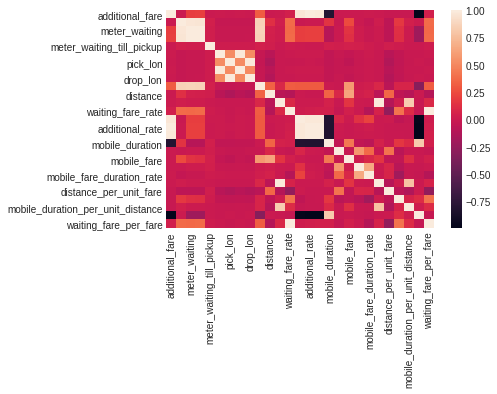

In [ ]:
#correlation
corr = x_train.corr()
sns.heatmap(corr)

## Train labels

In [ ]:
# Encode target variable
y_train = pd.DataFrame(x_train.pop('label'),columns=['label'])
le = LabelEncoder()
y_train['label'] = le.fit_transform(y_train['label'])
y_train['label'] = y_train['label'].replace({0: 1, 1: 0})

# Model creation and training

In [ ]:
# Create preprocessing pipeline

#feature selection
dropped_features = ['waiting_duration_rate', 'additional_rate', 'mobile_fare','mobile_duration','mobile_fare_duration_rate',
                    'mobile_fare_distance_rate',
                    'mobile_duration_per_unit_distance',
                    'mobile_duration_fare_rate',
                    'mod_mobile_fare',
                    'duration_per_unit_fare','picup_hour',
                    'drop_hour',
                    'pickup_day',
                    'drop_day','pickup_day_of_week','drop_day_of_week','pickup_year','drop_year']

numeric_columns = ['meter_waiting_till_pickup',
                   'additional_fare',
                   'meter_waiting',
                   'meter_waiting_fare',
                   'distance',
                   'duration',
                   'fare',
                   'fare_per_unit_distance',
                   'waiting_fare_rate',
                   'waiting_fare_per_fare',
                   'velocity',
                   'fare_rate',
                   'mobile_fare_rate',
                   'distance_per_unit_fare']
                   
categorical_columns = []

numeric_preprocessing_steps = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='mean')),
    ('standard_scaler',StandardScaler())
])

categorical_preprocessing_steps = Pipeline ([                               
    ('categorical_imputer', SimpleImputer(strategy ='most_frequent')),
    ('encode', OneHotEncoder()),

])

# preprocessing steps of the pipeline
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_columns),
        ("categorical",categorical_preprocessing_steps,categorical_columns)
    ],
    remainder = "drop"
)

## Random Forest

In [ ]:
#hyper-parameter tuning for model selection

RANDOM_SEED = 6  
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2,
    shuffle=True,
    stratify=y_train,
    random_state=RANDOM_SEED) 

estimator =  RandomForestClassifier()
param_grid={
        'estimator__n_estimators' = [50,100,200,300],
        'estimator__max_depth' = [3,6,10,20,23,25],
        'estimator__min_samples_leaf' = 1,
        'estimator__min_samples_split' = [4,5,7,8],
        'estimator__class_weight' = {0: 0.7605263157894736, 1: 0.2394736842105264},
        'estimator__random_state' = 500
}

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("feature_selection",SelectFromModel(LinearSVC(loss='l2', penalty='l1', dual=False,max_iter=1000))),
    ("estimator", estimator),cross validation
])

weights = np.linspace(0.05, 0.95, 20)

g_search = GridSearchCV(estimator=full_pipeline, param_grid = param_grid,cv=5)
g_fit = g_search.fit(X_train, Y_train['label'])
best_params = g_fit.best_params_
print(best_params)
print(g_fit.best_estimator_.score(X_test,Y_test))

In [ ]:
feature_importances = g_fit.best_estimator_.named_steps['estimator'].feature_importances_
x_importance = pd.DataFrame(feature_importances,columns=['relative_importance'])
x_importance ['variable'] = numeric_columns
plt.figure(figsize=(20, 10))
sns.barplot(x="relative_importance", y="variable", label='big',data=x_importance.sort_values(by="relative_importance", ascending=False))
plt.title('Feature importance - Random Forest')
plt.tight_layout()
plt.show()

Feature: 0, Score: 0.03180
Feature: 1, Score: 0.02097
Feature: 2, Score: 0.04239
Feature: 3, Score: 0.02212
Feature: 4, Score: 0.04999
Feature: 5, Score: 0.06088
Feature: 6, Score: 0.08228
Feature: 7, Score: 0.09407
Feature: 8, Score: 0.02252
Feature: 9, Score: 0.02395
Feature: 10, Score: 0.08517
Feature: 11, Score: 0.15668
Feature: 12, Score: 0.23304
Feature: 13, Score: 0.07415


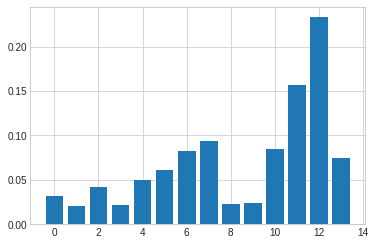

In [ ]:
for i,v in enumerate(feature_importances):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(feature_importances))], feature_importances)
plt.show()

In [ ]:
# confution matrix
pred = g_fit.best_estimator_.predict(X_test)
pd.crosstab(pred,Y_test['label'],rownames=['predicted'],colnames=['actual'])

actual,0,1
predicted,,
0,224,48
1,112,3050


plot trees in forest

In [ ]:
#plot trees
import os
from sklearn.tree import export_graphviz
import six
import pydot
from sklearn import tree
dotfile = six.StringIO()
i_tree = 0
for tree_in_forest in g_fit.best_estimator_.named_steps['estimator'].estimators_:
  if(i_tree<3):
    export_graphviz(tree_in_forest,out_file='tree.dot',
    feature_names=numeric_columns,
    filled=True,
    rounded=True)
    (graph,) = pydot.graph_from_dot_file('tree.dot')
    name = 'tree' + str(i_tree)
    graph.write_png(name+  '.png')
    os.system('dot -Tpng tree.dot -o tree.png')
    i_tree +=1
  else:
    break

## XGBoost

In [ ]:
#XGBoost
import xgboost as xgb
RANDOM_SEED = 6  
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2,
    shuffle=True,
    stratify=y_train,
    random_state=RANDOM_SEED) 


# define grid
weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)

estimator = xgb.XGBClassifier(n_estimators=100,max_depth=20,estimator__eta=0.1,
                              min_child_weight=1,gamma=0.3,colsample_bytree=0.5,learning_rate = 0.15,sub_sample=1)
parameters = {
      #"estimator__eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ]
     #"estimator__max_depth"        : [ 3, 10, 12, 15,20,23,25]
      #"estimator__min_child_weight" : [ 1, 3, 5, 7 ]
      #"estimator__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
      #"estimator__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
      #"estimator__learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ]
      #'estimator__subsample': [0.6, 0.8, 1.0]
      'estimator__scale_pos_weight':[1, 10, 25, 50, 75, 99, 100, 1000]
     }

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("feature_selection",SelectFromModel(LinearSVC(loss='l2', penalty='l1', dual=False,max_iter=1000))),
    ("estimator", estimator),
])

grid = GridSearchCV(full_pipeline,parameters, n_jobs=4,cv=3)
g_fit = grid.fit(X_train, Y_train)
print(g_fit.best_params_)
print(g_fit.best_estimator_.score(X_test,Y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_classes.py:226: FutureWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 0.23
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-pac

{'estimator__scale_pos_weight': 1}
0.9568155111633373


In [ ]:
# confution matrix
pred = g_fit.best_estimator_.predict(X_test)
pd.crosstab(pred,Y_test['label'],rownames=['predicted'],colnames=['actual'])

actual,0,1
predicted,,
0,179,24
1,127,3074


## Using catboost

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier, Pool

In [ ]:
x_train_1 = x_train[numeric_columns]
train_data, test_data,train_labels, test_labels = train_test_split(x_train_1, y_train, test_size=0.2,
    shuffle=True,
    stratify=y_train,
    random_state=RANDOM_SEED) 

model = CatBoostClassifier(eval_metric='F1',iterations=1000,loss_function='Logloss',use_best_model=True)
model.fit(train_data,train_labels,plot=True,eval_set=(test_data,test_labels),verbose=False)
print(model.score(test_data,test_labels))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.9569015725101921


In [ ]:
# confution matrix
pred = model.predict(test_data)
pd.crosstab(pred,test_labels['label'],rownames=['predicted'],colnames=['actual'])

actual,0,1
predicted,,
0,227,39
1,109,3059


## Fit the best model

In [ ]:
model = CatBoostClassifier(eval_metric='F1',iterations=1000,loss_function='Logloss')
model.fit(x_train[numeric_columns],y_train,plot=True,verbose=False)
pred = model.predict(x_test[numeric_columns])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
#plot tree
pool = Pool(x_train[numeric_columns],y_train, feature_names=numeric_columns)
model.plot_tree(
    tree_idx=0,
    pool=pool
)
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
  

## Generate output

In [ ]:
# Generate the best model for the whole dataset.
# g_search = GridSearchCV(full_pipeline, parameters)
# g_fit = g_search.fit(x_train, y_train['label'])
# best_clf = g_fit.best_estimator_

# generate the predictions for the test dataset
cls_lbls = pd.Series(pred)
prediction = pd.DataFrame(cls_lbls,columns=['prediction'])
output = pd.DataFrame()
output['tripid'] = tripid_test
output['prediction'] = prediction['prediction']

output.to_csv('/content/drive/My Drive/Colab Notebooks/data/ml-rideshare/output-new-predictions-3.csv',index = False)